In [1]:
import pandas as pd
import numpy as np

import os 
import sys

os.chdir('..') ; sys.path.append(os.getcwd())

In [2]:
Xy = pd.read_parquet('data/feature_matrix_train_vMLP.parquet')

# features = np.loadtxt('data/features.txt', dtype=str)

dtid_ohe = pd.get_dummies(Xy['dtid'])
Xy.drop('dtid', axis=1, inplace=True)
Xy = pd.concat([Xy, dtid_ohe], axis=1)

Xy.head()

,motion,speed,radius,seqnumber,rssi8245,rssi16082,rssi3562,rssi14280,rssi1743,rssi3558,...,5aa2b2e95005741b7d664456,5aafc3cf9e93a13199a1d3e0,5ad494bd9e93a128c8abfca4,5ad49def3c87894334c6d764,5ad7077f9e93a128c85029d7,5af2bdf49e93a128c8cbbc19,5afbe2c59058c264249ac174,5afd4b7c9058c26424f713c5,5b0ef3125005747bb07f99eb,5b115d0b9058c20630b137df
5a497a24cf554f30e846c069,0,1.0,0.0,283,-121.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5a497a4ce541cd714d45b1c5,0,1.0,0.0,194,0.0,0.0,0.0,-139.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5a497a4dcf554f30e8472041,0,0.0,0.0,2598,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5a497aafcf554f30e847cc61,0,0.0,0.0,2721,-113.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5a497adde541cd714d46accb,0,1.0,0.0,1898,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_test = pd.read_parquet('data/feature_matrix_test_vMLP.parquet')

dtid_ohe = pd.get_dummies(X_test['dtid'])
X_test.drop('dtid', axis=1, inplace=True)
X_test = pd.concat([X_test, dtid_ohe], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

from utils.evaluation import vincenty_df, vincenty_vec, criterion, plot_error
from geopy.distance import vincenty

In [5]:
features = list(X_test.columns) #list(Xy.columns)
# features.remove('latitude')
# features.remove('longitude')

In [6]:
# filter features
import re

r_nseq = re.compile('nseq')
nseqs = [x for x in features if r_nseq.match(x)]

r_time = re.compile('time_ux')
times = [x for x in features if r_time.match(x)]

r_freq = re.compile('freq')
freqs = [x for x in features if r_freq.match(x)]

r_snr = re.compile('snr')
snrs = [x for x in features if r_snr.match(x)]

r_dist = re.compile('estim_distance')
dists = [x for x in features if r_dist.match(x)]


In [7]:
X, y = Xy.loc[:, features], Xy.loc[:, ['latitude', 'longitude']]

X.drop(nseqs + times + freqs + snrs, axis=1, inplace=True )
X_test.drop(nseqs + times + freqs + snrs, axis=1, inplace=True )

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=0)

scaler = StandardScaler() # reuse for test
# X_train_scale = scaler.fit_transform(X_train)
# X_val_scale = scaler.transform(X_val)
X_scale = scaler.fit_transform(X)
X_test_scale = scaler.transform(X_test)

/cluster/storage/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/cluster/storage/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/cluster/storage/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.5/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [8]:
# X_train.shape
X.shape, X_test.shape

((957567, 659), (89967, 659))

In [33]:
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_scale)

print(X_train_pca.shape)

[[-3.22286541e+00 -4.25833967e+00 -1.67220645e+00 ...  7.73082098e-01
   1.53054839e-01 -1.29622410e-01]
 [ 2.73635826e+00 -7.17441702e+00 -1.81923890e+00 ...  1.11130162e+00
   2.92141260e-01 -5.65293204e-01]
 [-1.12079153e+00 -1.48534663e+00  2.81027927e+00 ...  1.58260756e-01
  -2.00564309e-01 -5.26314746e-01]
 ...
 [-5.58310894e+00 -4.99124006e+00 -6.87082258e+00 ... -3.06100137e-03
  -3.09932992e-02  2.73081544e-02]
 [-3.17945957e-01 -4.80748390e+00  1.36476195e+00 ...  8.61891602e-01
   4.94292565e-01  1.64187134e-01]
 [-2.56482055e+00 -4.78907996e+00 -4.33105271e+00 ... -5.60989984e-01
  -1.39179589e-01  1.32263595e-02]]


### Masking extreme values

In [10]:
mean_lat, std_lat = y['latitude'].mean(), y['latitude'].std()
mean_lng, std_lng = y['longitude'].mean(), y['longitude'].std()

mask = (y['latitude'] < mean_lat + 2*std_lat ) & (y['latitude'] > mean_lat - 2*std_lat) & \
    (y['longitude'] < mean_lng + 2*std_lng) & (y['longitude'] > mean_lng - 2*std_lng)

In [11]:
mask.shape, mask.sum()

((957567,), 950381)

### Removing non significative features

In [12]:
n_zeros = np.count_nonzero(X_train, axis=0)

treshold = int(X_train.shape[0] // 10)

feature_mask = np.where(n_zeros >= treshold, True, False)
feature_mask.shape, feature_mask.sum()

((673,), 209)

### $\chi$-2 feature selection

In [14]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [69]:
def select_best_coefs(coefs_df, k=10):
    # coefs.shape=(n_features, 2), has to be sorted
    coef_list = []
    

In [70]:
lin_reg = LinearRegression().fit(X_train[::10], y_train[::10])

coefs = lin_reg.coef_.T

In [78]:
coefs_df = pd.DataFrame(coefs, columns=['coef_lat', 'coef_lng'], index=X_train.columns)
coefs_df['abs_lat'], coefs_df['abs_lng'] = np.abs(coefs_df['coef_lat']), np.abs(coefs_df['coef_lng'])
coefs_df.sort_values(['abs_lat', 'abs_lng'], ascending=False, inplace=True)
coefs_df.head()

,coef_lat,coef_lng,abs_lat,abs_lng
nseq4047,-0.083683,0.060346,0.083683,0.060346
fast,0.079604,0.013482,0.079604,0.013482
nseq4148,0.074201,0.034470,0.074201,0.034470
5a3299549e93a149fc95c626,-0.069662,-0.043624,0.069662,0.043624
nseq3389,0.051088,-0.002440,0.051088,0.002440


In [79]:
# best_coefs = np.array(select_best_coefs(coefs_df, X.shape[1]//2))
best_coefs = coefs_df.iloc[:X.shape[1]//2, :].index

print(best_coefs.shape)
best_coefs

(575,)


Index(['nseq4047', 'fast', 'nseq4148', '5a3299549e93a149fc95c626', 'nseq3389',
       'nseq26828', 'snr34453', 'rssi34453', 'nseq3402', 'nseq1092',
       ...
       'rssi4993', 'estim_distance3500', 'estim_distance9054', 'snr3581',
       'distance3545', 'estim_distance3565', 'estim_distance10943',
       'estim_distance8471', 'estim_distance4059', 'snr10151'],
      dtype='object', length=575)

In [82]:
X_train_red = X_train.loc[:, best_coefs]
X_val_red = X_val.loc[:, best_coefs]

## Regression

In [10]:
%%time
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score

custom_loss = make_scorer(criterion, is_df=False)

rf = RandomForestRegressor(n_estimators=130, 
                           max_features='sqrt',
                           max_depth=70,
                           n_jobs=30, verbose=1)

sgd = MultiOutputRegressor(SGDRegressor(verbose=2, 
                                        alpha=0.1, penalty='l2',                            
                                        early_stopping=True,
                                        fit_intercept=True,
                                        learning_rate='adaptive',
                                        max_iter=30))

# xgb = MultiOutputRegressor(XGBRegressor(n_estimators=50, n_jobs=8, **{'tree_method':'approx'}))
gbt = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=50), n_jobs=-1)

knn = KNeighborsRegressor()

gp = GaussianProcessRegressor()

# lr = MultiOutputRegressor(LogisticRegression(n_jobs=30))
lr = ElasticNet(selection='random')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 321 µs


In [13]:
%%time
cv = cross_val_score(gbt, X_train.loc[mask, feature_mask], y_train[mask].values, 
                     scoring=custom_loss, cv=5, verbose=3, n_jobs=16)

print(cv.mean(), cv.std())

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of   5 | elapsed: 21.6min remaining: 32.3min


8.015199024159832 0.0148694521224264
CPU times: user 5.33 s, sys: 9.44 s, total: 14.8 s
Wall time: 23min 54s


[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed: 23.8min finished


In [11]:
df_ytest = pd.DataFrame(y_val, columns=['latitude', 'longitude'])

In [14]:
%%time
clf = xgb.fit(X_train.loc[:, :], y_train[:])


pred_rf = pd.DataFrame(clf.predict(X_val.loc[:, :]), columns=['pred_lat', 'pred_long'], index=y_val.index)


print('criterion for random forest: {:.3f}'\
      .format(criterion(pred_rf[['pred_lat', 'pred_long']], df_ytest, True)))

NameError: name 'xgb' is not defined

In [17]:
from geopy.distance import geodesic

def geo_distance(x, y): 
    return geodesic((x[0], x[1]), (y[0], y[1])).m

In [33]:
%%time
p = int(np.sqrt(X.shape[1]))
knn = KNeighborsRegressor(n_neighbors=5, metric=geo_distance)
knn.fit(rf.predict(X_train_scale), y_train)
pred_knn = pd.DataFrame(knn.predict(rf.predict(X_val_scale)), columns=['pred_lat', 'pred_long'], index=y_val.index)

print('criterion for random forest: {:.3f}'\
      .format(criterion(pred_knn[['pred_lat', 'pred_long']], df_ytest, True)))

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:    0.6s remaining:    4.1s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:    0.2s finished


KeyboardInterrupt: 

In [34]:
criterion(pred_knn[['pred_lat', 'pred_long']], df_ytest, True)

8.228960773093362

/cluster/storage/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


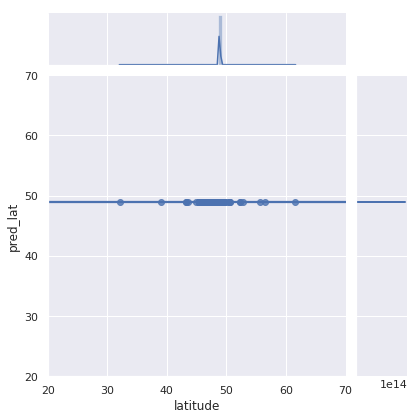

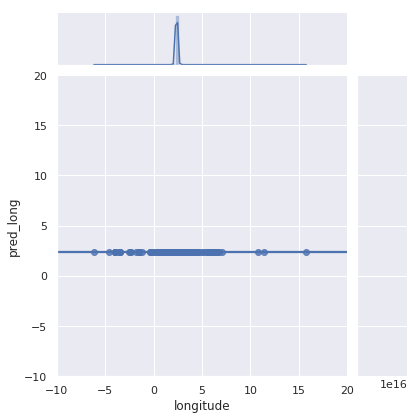

In [26]:
sns.jointplot(df_ytest['latitude'], pred_rf['pred_lat'], xlim=(20, 70), ylim=(20, 70), kind='reg')
sns.jointplot(df_ytest['longitude'], pred_rf['pred_long'], xlim=(-10, 20), ylim=(-10, 20), kind='reg')

## xgboost

In [18]:
import xgboost 
from sklearn.multioutput import MultiOutputRegressor

In [24]:
%%time
xgb = MultiOutputRegressor(xgboost.XGBRegressor(max_depth=10,n_jobs=24), n_jobs=-1)

cv_xgb = cross_val_score(xgb, X_pca, y.values, scoring=custom_loss, cv=5, verbose=4, n_jobs=24)

print(cv.mean(), cv.std())

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of   5 | elapsed: 50.5min remaining: 75.7min


6.9099899943074705 0.8804104690168645
CPU times: user 1.28 s, sys: 10.1 s, total: 11.4 s
Wall time: 52min 1s


[Parallel(n_jobs=24)]: Done   5 out of   5 | elapsed: 52.0min finished


## Prediction

In [13]:
mean_lat, std_lat = y['latitude'].mean(), y['latitude'].std()
mean_lng, std_lng = y['longitude'].mean(), y['longitude'].std()

mask = (y['latitude'] < mean_lat + std_lat ) & (y['latitude'] > mean_lat - std_lat) & \
    (y['longitude'] < mean_lng + std_lng) & (y['longitude'] > mean_lng - std_lng)

In [14]:
mask.shape, mask.sum()

((957567,), 807086)

In [13]:
%%time
rf = RandomForestRegressor(n_estimators=130, 
                           max_features='sqrt',
                           max_depth=70,
                           n_jobs=30, verbose=1).fit(X.loc[mask, :], y[mask].values)

# xgb = MultiOutputRegressor(xgboost.XGBRegressor(max_depth=10,n_jobs=24), n_jobs=-1)
# xgb.fit()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 130 out of 130 | elapsed:  1.6min finished


CPU times: user 44min 9s, sys: 14.8 s, total: 44min 24s
Wall time: 1min 45s


In [14]:
test_pred = pd.DataFrame(rf.predict(X_test), columns=['latitude', 'longitude'])
test_pred['messageid'] = X_test.index

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 130 out of 130 | elapsed:    0.8s finished


In [16]:
test_pred.to_csv('data/prediction_rf.csv')

In [20]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
%%time
knn = KNeighborsRegressor(n_neighbors=3, metric=geo_distance)
knn.fit(rf.predict(X), y)
pred_knn = pd.DataFrame(knn.predict(rf.predict(X_test)), columns=['pred_lat', 'pred_long'], index=y_val.index)

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 130 out of 130 | elapsed:    9.8s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 130 out of 130 | elapsed:    0.8s finished


In [ ]:
pred_knn.head()

In [ ]:
1

In [21]:
from joblib import dump

dump(rf, 'data/clf/rf_6.9.joblib')


['data/clf/rf_6.9.joblib']

In [14]:
import seaborn as sns

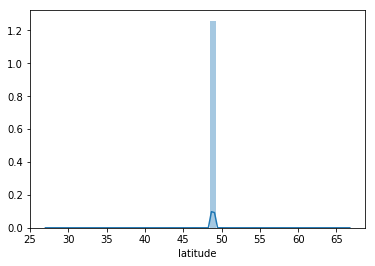

In [19]:
sns.distplot(Xy['latitude'])

/cluster/storage/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


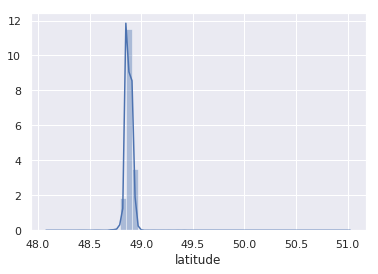

In [21]:
sns.distplot(test_pred['latitude'])

In [ ]:
sns.jointplot(x=Xy['longitude'], y=test_pred['longitude'], 

In [22]:
test_pred.to_csv('data/prediction_rf.csv')

In [39]:
print('DONE')

DONE


In [40]:
test_pred.describe()

,latitude,longitude
count,89967.000000,89967.000000
mean,48.876227,2.308530
std,0.044139,0.063993
min,48.526153,1.741678
25%,48.851955,2.281289
50%,48.868848,2.314087
75%,48.890736,2.343436
max,49.547996,2.663995


In [41]:
y.describe()

,latitude,longitude
count,957567.000000,957567.000000
mean,48.878232,2.363743
std,0.123753,0.171150
min,27.029945,-27.022779
25%,48.835434,2.290130
50%,48.876179,2.350454
75%,48.919693,2.429126
max,66.717812,31.491501
